## 데이터셋 EDA

| 구분        | 개수  | fake여부   | 기반   | 사이즈     | train(%) | val(%) | test(%) |
| ----------- | ----- | ---------- | ------ | ---------- | -------- | ------ | ------- |
| FFHQ        | 35000 | 0          |        | 1024, 1024 | 70       | 10     | 20      |
| LFW         | 13233 | 0          |        | 250, 250   | 70       | 10     | 20      |
| CelebA      | 17767 | 0          |        | 178, 218   | 70       | 10     | 20      |
| StarGAN     | 6000  | 1          | CelebA | 1024, 1024 | 70       | 10     | 20      |
| StyleGAN1   | 30000 | 1          | FFHQ   | 1024, 1024 | 70       | 10     | 20      |
| StyleGAN2   | 30000 | 1          | FFHQ   | 1024, 1024 | 70       | 10     | 20      |
| StyleGAN-XL | 13200 | 1 (unseen) | FFHQ   | 256, 256   | 0        | 0      | 100     |



각 데이터는  아래와 같은 형태로 저장되어 있다.

```
dataset
├── CelebA
├── FFHQ
├── LFW
├── StarGAN
├── StyleGAN1
├── StyleGAN2
└── StyleGANXL
```
real, fake 얼굴 사진 각각 66,000 장을 사용한다. StyleGANXL 데이터는 학습에 사용하지 않고, 테스트 시에만 사용한다.

학습 과정에서 모든 데이터를 램에 올리기에는 데이터의 양이 너무 많기 때문에 train, val, test 데이터 들의 경로가 포함된  csv 파일을 만들어준다.



# 1. 데이터셋 준비

In [5]:
import os
import pandas as pd
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from scipy.fftpack import fft2, fftshift
import numpy as np
import pathlib
from pathlib import Path, PosixPath 

import cv2 
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix as cm, classification_report as cr


In [ ]:
# weight 저장 시점 구분을 위해 import
from datetime import datetime
from pytz import timezone

datetime.now(timezone('Asia/Seoul')).strftime("%Y-%m-%d-%H-%M-%S")

In [ ]:
# 필요한 library import
from torchvision.io import read_image

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

import copy
import time

from sklearn import metrics

# convolution 수행 과정에서 벤치마킹을 통해 지금 환경에 가장 적합한 알고리즘 선정하여 수행
# 이미지 크기가 자주 변하지 않는다면 성능 향상에 도움
cudnn.benchmark = True

In [6]:
def makeCSV(path, label, tag, dst=None):
    """
    path: 사진이 들어있는 폴더의 경로
    label: 0이면 진짜 사진, 1이면 가짜 사진
    tag: 이후에 분석을 쉽게 하기 위해 폴더 이름을 tag로 넣어줌

    return: path 내부에 있는 모든 사진의 경로와 label, tag를 행으로 갖는 csv 파일
    """
    path = pathlib.PosixPath(path) # path 설정
    generator = path.glob("./*") # 경로 이하의 파일을 뱉는 generator 생성
    nullList = list() # 빈 파일 경로가 들어있는 리스트
    fileList = list() # 정상적인 파일의 경로가 들어있는 리스트

    i = 0
    while True:
        i += 1
        try:
            filepath = generator.__next__() # 파일의 경로를 하나씩 받아온다
            if os.stat(filepath).st_size == 0: # 파일 사이즈가 0인 null file을 검사한다
                nullList.append(filepath)
            else:
                fileList.append(filepath)
        except: # 더 이상 남은 파일이 없으면 while 문을 빠져나간다
            break
        if i % 1000 == 0: # 1000 간격으로 진행도를 보여준다
            clear_output()
            print(i)
    csv = pd.DataFrame({
        'filepath': fileList,
        'label': label,
        'tag': tag
    })

    if dst: # 저장할 경로가 존재하면 저장하고 리턴값은 None
        csv.to_csv(dst)
        return
    
    return csv, nullList

In [9]:
dirList = list(pathlib.PosixPath("./dataset").glob("./*"))

# 아래 값을 적절하게 조절해서 csv 폴더 생성, dirList에는 dataset 폴더들의 이름이 들어 있음
makeCSV(dirList[0], label=0, tag="FFHQ", dst=f"./csv/{dirList[0].name}")

In [ ]:
csvList = list(pathlib.PosixPath("./csv/").glob("./*.csv"))
# 여기에 styleGAN-XL에 해당하는 index만 pop으로 솎아준다
csvList.pop(4)

# XL을 제외한 모든 데이터들을 넣어준다
df = pd.DataFrame()
for csv in csvList:
    temp = pd.read_csv(csv, index_col=0)
    df = pd.concat([df, temp], axis=0)

In [ ]:
# 지금은 안 섞인 상태니까 한번 섞어준다
train, test = train_test_split(df ,test_size=0.2, shuffle=True)

train, val = train_test_split(train, test_size=0.125)

train.to_csv("./csv/train.csv")
val.to_csv("./csv/val.csv")
test.to_csv("./csv/test.csv")

In [ ]:
# XL 전용 테스트 
xl = pd.read_csv("./csv/StyleGANXL", index_col=0)
xl = xl.sample(13200)
test = test[test.label == 0]

test_xl = pd.concat([xl, test], axis=0)
# 한번 섞어서 저장한다
test_xl = test_xl.sample(len(test_xl))
test_xl.to_csv("./csv/test_XL.csv")

# 2. 데이터 전처리

## 2.1. Benford First Digits Probability Distribution

각 이미지를 DCT 를 이용해 전처리하고 한 이미지에서 각 digit의 첫 번쨰 숫자 빈도를 센다

In [ ]:

def compute_first_digits(img, normalize=True):
    # 이미지를 gray scale로 읽어옴
    if isinstance(img, str):
        img = cv2.imread(img, 0)
    # 컬러 이미지가 들어오면 gray scale 로 바꿔줌
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

    # dct 는 shape이 짝수여야 한다고 함, 홀수면 처리를 해줌
    if img.shape[0] % 2:
        img = img[:img.shape[0] - 1,:]
    
    if img.shape[1] % 2:
        img = img[:,:img.shape[1] - 1]

    # 0 ~ 255 로 normalize 
    if normalize:
        img = cv2.normalize(img, np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX)
    
    # 0 ~ 1 로 다시 normalize 후 descrete cosine transform, 어짜피 First Digit 만 구할꺼니 abs 까지
    img = cv2.dct(np.float32(img) / 255.0)
    img = np.abs(img)

    # 0 인 경우 로그에 들어갈 때 문제가 생김
    img = img[img != 0]
    min_val = img.min()

    if min_val < 1:
        img = np.power(10, -np.floor(np.log10(min_val))) * img

    # 위 코드를 지나면 모두 1.0 보다 커야함
    if not (img >= 1.0).all():
        raise ValueError("Error")
    
    # [1, 10) 은 0, [10, 100) 은 1, 이런느낌
    digits = np.log10(img).astype(int).astype('float32')
    first_digits = img / np.power(10, digits)
    first_digits = first_digits.astype(int)

    # 혹시라도 0이 들어있는 부분이 있다면 예외처리해준다
    first_digits = first_digits[first_digits != 0]

    
    return first_digits

def compute_first_digits_counts(img, normalise=True):
    first_digits = compute_first_digits(img, normalise)
    unq, counts = np.unique(first_digits, return_counts=True)
    return unq, counts

def compute_first_digits_prob(img, normalise=True):
    unq, counts = compute_first_digits_counts(img, normalise)
    counts = counts / sum(counts)
    return counts

In [ ]:
# train val test XL 각각의 파일경로들을 불러온다
train_filepath = pd.read_csv("./csv/train.csv", index_col=0).filepath.values
val_filepath = pd.read_csv("./csv/val.csv", index_col=0).filepath.values
test_filepath = pd.read_csv("./csv/test.csv", index_col=0).filepath.values
test_XL_filepath = pd.read_csv("./csv/test_XL.csv", index_col=0).filepath.values

In [ ]:
# 불러온 경로들을 사용해 위에서 미리 정의한 함수들을 사용해서 확률분포로 전처리해줌
train = np.array([compute_first_digits_prob(i) for i in train_filepath])
val = np.array([compute_first_digits_prob(i) for i in val_filepath])
test = np.array([compute_first_digits_prob(i) for i in test_filepath])
test_XL = np.array([compute_first_digits_prob(i) for i in test_XL_filepath])

In [ ]:
# npy 폴더에 저장
np.save("./npy/train", train)
np.save("./npy/val", val)
np.save("./npy/test", test)
np.save("./npy/test_XL", test_XL)

In [ ]:
# 전처리가 완료된 확률분포를 불러옴
x_train = np.load("./npy/train")
x_val = np.load("./npy/val")
x_test = np.load("./npy/test")
x_test_XL = np.load("./npy/test_XL")

In [ ]:
# label도 따로 불러옴
y_train = pd.read_csv("./csv/train.csv", index_col=0).label.values
y_val = pd.read_csv("./csv/val.csv", index_col=0).label.values
y_test = pd.read_csv("./csv/test.csv", index_col=0).label.values
y_test_XL = pd.read_csv("./csv/test_XL.csv", index_col=0).label.values

train, val 을 합쳐준다

In [ ]:
x_train = np.concatenate([x_train, x_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0)
del x_val, y_val

## 2.2. deep learning(backbone)

In [ ]:
# gpu 사용 여부 설정 및 확인
use_cuda = True
device = 'cuda:0' if torch.cuda.is_available() and use_cuda else 'cpu'
print(device)

In [ ]:
# 커스텀 데이터셋 클래스 생성
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, index_col=0).reset_index()
        self.img_filepath = self.img_labels.filepath
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_filepath.iloc[idx])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
# 이미지 전처리 세팅(크기 조정) 및 batch 사이즈 설정 
transform = transforms.Compose(
    [transforms.Resize((224,224)), 
    ])

batch_size = 128

In [ ]:
# 데이터셋 할당 및 데이터로더(제너레이터) 할당
trainset = CustomImageDataset(r'C:\Users\Public\project3\real_csv\train_tc_sh.csv', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

valset = CustomImageDataset(r'C:\Users\Public\project3\real_csv\val_tc_sh.csv', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = CustomImageDataset(r'C:\Users\Public\project3\real_csv\test_tc_sh.csv', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=0)

datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {'train': trainloader, 'val': valloader, 'test': testloader}
datasets_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

In [ ]:
# 데이터셋 크기 확인
datasets_sizes

## 2-3. deep learning(spectrum)

In [ ]:
#array를 dct two-Dimension로 변환한다  
def dct2(array, batched=True):
    shape = array.shape
    dtype = array.dtype
    array = tf.cast(array, tf.float32)

    if batched:
        # layout (B)atch, (R)ows, (C)olumns, (V)alue
        # BRCV
        array = tf.transpose(array, perm=[0, 3, 2, 1])
        # BVCR
        array = tf.signal.dct(array, type=2, norm="ortho")
        array = tf.transpose(array, perm=[0, 1, 3, 2])
        # BVRC
        array = tf.signal.dct(array, type=2, norm="ortho")
        #원상복구
        array = tf.transpose(array, perm=[0, 2, 3, 1])
        # BRCV
    else:
        # RCV
        array = tf.transpose(array, perm=[2, 1, 0])
        # VCR
        array = tf.signal.dct(array, type=2, norm="ortho")
        array = tf.transpose(array, perm=[0, 2, 1])
        # VRC
        array = tf.signal.dct(array, type=2, norm="ortho")
        array = tf.transpose(array, perm=[1, 2, 0])
        # RCV


    array = tf.cast(array, dtype)
    array.shape.assert_is_compatible_with(shape)

    return array


In [ ]:
# 각기 다른 크기의 이미지를 일정한 크기로 자르는 함수 구현 
def crop(image_path):
    image = np.asarray(Image.open(image_path))
    x,y,_ = image.shape
    image = np.copy(image)
    x_upper = min(300+64, x) 
    y_upper = min(200+64, y)  
    image = image[x_upper-128:x_upper, y_upper-128:y_upper]
    image = np.clip(image,0,255.).astype(np.uint8)
    return image

In [ ]:
class My_Custom_Generator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, labels, batch_size) -> None:
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
    
    def __getitem__(self, index):
        batch_x = self.image_filenames[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y = self.labels[index * self.batch_size: (index + 1) * self.batch_size]
        
        #list comprehension을 사용하여 batch_x 안의 image_path에 있는 모든 이미지에 대해 crop 함수 적용
        image_x = np.asarray([crop(image_path) for image_path in batch_x])
        
        #이미지 crop 이후 array 변환한 결과와 label을 함께 반환
        return image_x, batch_y

In [ ]:
#batch size 정의 
batch_size = 128
#train, validation generator 생성
train_generator = My_Custom_Generator(train_filepath, y_train, batch_size)
val_generator = My_Custom_Generator(val_filepath, y_val, batch_size)

# 3. 학습 모델 훈련

## 3.1. machine learning(Benford's law 이용)

전처리한 결과를 이용해 머신러닝 시작

In [ ]:
rf = RandomForestClassifier(verbose=1, n_jobs=-1)
rf.fit(x_train, y_train)
y_rf_pred = rf.predict(x_test)
y_rf_proba = rf.predict_proba(x_test)

print(cm(y_true=y_test, y_pred=y_rf_pred))
print(cr(y_true=y_test, y_pred=y_rf_pred))

In [ ]:
svc =  SVC(random_state=0,verbose=1,probability=True)
svc.fit(x_train, y_train)
y_svc_pred = svc.predict(x_test)
y_svc_proba = svc.predict_proba(x_test)

print(cm(y_true=y_test, y_pred=y_svc_pred))
print(cr(y_true=y_test, y_pred=y_svc_pred))

In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50, 20), 
    verbose=1, 
    early_stopping=True, 
)

mlp.fit(x_train, x_test)
y_mlp_pred = mlp.predict(x_test)
y_mlp_proba = mlp.predict_proba(x_test)

print(cm(y_true=y_test, y_pred=y_mlp_pred))
print(cr(y_true=y_test, y_pred=y_mlp_pred))

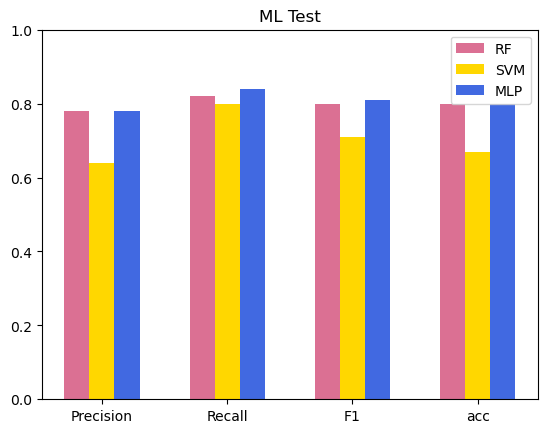

In [ ]:
topics = ['Precision', 'Recall', 'F1', 'acc']

RF = [0.78, 0.82, 0.80, 0.80]
SVM = [0.64, 0.80, 0.71, 0.67]
MLP = [0.78, 0.84, 0.81, 0.80]

def create_x(t, w, n, d):
    return [t*x + w*n for x in range(d)]

RF_x = create_x(4, 0.8, 1, 4)
SVM_x = create_x(4, 0.8, 2, 4)
MLP_x = create_x(4, 0.8, 3, 4)


ax = plt.subplot()
ax.bar(RF_x, RF, label='RF', color='palevioletred')
ax.bar(SVM_x, SVM, label="SVM", color='gold')
ax.bar(MLP_x, MLP, label="MLP", color='royalblue')

middle_x = [(a+b+c)/3 for (a,b, c) in zip(RF_x, SVM_x, MLP_x)]
ax.set_xticks(middle_x)
ax.set_xticklabels(topics)

plt.ylim((0, 1))
plt.title("ML Test")
plt.legend(loc=1)
plt.show()

In [ ]:
# ROC curve 그리는 함수 선언
def plotROC(label, *probs):
  for prob, name, color in zip(probs, ['RF', 'SVM', 'MLP'], ['palevioletred', 'gold', 'royalblue']):
    fpr, tpr, thresholds = metrics.roc_curve(label, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f'{name} (AUC = {roc_auc:.2f})')

  plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='slategray')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ML Test')
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.legend()
  plt.show()

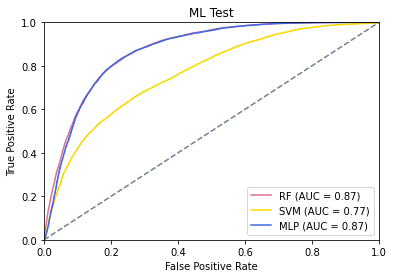

In [ ]:
plotROC(label, rf_pred[:,1], svc_pred[:,1], mlp_pred[:,1])

## 3.2. deep learning(backbone)

In [ ]:
# 학습(train)과 검증(validation) 진행하는 함수 설정
def train_model(model, criterion, optimizer, num_epochs, scheduler=None):
    # 시작 시간 변수 할당
    since = time.time()

    # best 성능 모델 weights 및 accuracy 초기화
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # num_epochs에 할당한 숫자 만큼 반복
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*10)

    # 각 epoch은 학습 단계와 검증 단계 가짐
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # 모델 학습모드로 설정
            else:
                model.eval() # 모델 평가모드로 설정
      
            # loss와 맞은 개수 할당 및 초기화
            running_loss = 0.0
            running_corrects = 0

            
            # 진행 상황 확인 위해 batch당 loss와 맞은 개수 할당 및 초기화
            batch_loss = 0.0
            batch_corrects = 0

            # 제너레이터인 데이터로더를 통한 데이터 반복
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                # 인풋 이미지와 정답 label을 설정
                inputs = inputs.float().to(device)
                labels = labels.float().unsqueeze(1).to(device)

                # parameter gradient 0으로 설정
                optimizer.zero_grad()

                # 학습 때만 연산 기록 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss, 맞은 개수 합산
                batch_loss += loss.item()
                batch_pred = torch.special.expit(outputs) >= torch.FloatTensor([0.5]).to(device) # 예측값 할당(0 또는 1)
                batch_corrects += torch.sum(batch_pred == labels.data)
                # batch 10개당 loss의 평균과 accuracy 출력 및 초기화
                if i % 10 == 9:
                    print(f'[{epoch+1}, {i+1:5d}] batch_loss: {batch_loss / 10:.4f}')
                    print(f'[{epoch+1}, {i+1:5d}] batch_acc: {batch_corrects.double() / (10*batch_size):.4f}')
                    batch_loss = 0.0
                    batch_corrects = 0
                # epoch 당 loss 평균과 accuracy 출력
                running_loss += loss.item() * inputs.size(0)
                pred = torch.special.expit(outputs) >= torch.FloatTensor([0.5]).to(device) # 예측값 할당(0 또는 1)
                running_corrects += torch.sum(pred == labels.data)

            # 학습 단계이고 scheduler가 설정되어 있다면 최적화 진행
            if phase == 'train' and scheduler:
                scheduler.step()

            # epoch별 loss와 accuracy 할당 및 출력
            epoch_loss = running_loss / datasets_sizes[phase]
            epoch_acc = running_corrects.double() / datasets_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # best 모델 deepcopy 및 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                current_time = datetime.now(timezone('Asia/Seoul')).strftime("%Y-%m-%d-%H-%M-%S")
                torch.save(model.state_dict(), f'C:\\Users\\Public\\project3\\weigths\\e2s_224_{current_time}_epochs{epoch+1}_weights.pth')
                print(f'model saved in epochs {epoch+1}')

        print()

    # 걸린 시간 및 best accuracy 출력
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # best 모델의 weights 불러옴
    model.load_state_dict(best_model_wts)

    return model

In [ ]:
# backbone 모델 가져오기
backbone_e2s = torchvision.models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')
backbone_m3l = torchvision.models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')

In [ ]:
# backbone_e2s 모델 구조 확인
print(backbone_e2s)

In [ ]:
# backbone_m3l 모델 구조 확인
print(backbone_m3l)

In [ ]:
# backbone_e2s 모델 끝단 확인
backbone_e2s.classifier[1]

In [ ]:
# backbone_m3l 모델 끝단 확인
backbone_m3l.classifier[3]

In [ ]:
# backbone_e2s 모델의 weight값 고정
for param in backbone_e2s.parameters():
    param.requires_grad = False

# backbone_e2s 모델 끝단 out_features를 데이터셋에 맞게끔 이진 분류를 위해 1로 변경
backbone_e2s.classifier[1] = torch.nn.Linear(1280, 1)

In [ ]:
# backbone_m3l 모델의 weight값 고정
for param in backbone_m3l.parameters():
    param.requires_grad = False

# backbone_m3l 모델 끝단 out_features를 데이터셋에 맞게끔 이진 분류를 위해 1로 변경
backbone_m3l.classifier[3] = torch.nn.Linear(in_features=1280, out_features=1, bias=True)

In [ ]:
# es2) 끝단만 weight 변경이 가능하고 나머지 weight는 고정되어 있음을 확인
for param in backbone_e2s.parameters():
    print(param.requires_grad)

In [ ]:
# 끝단만 weight 변경이 가능하고 나머지 weight는 고정되어 있음을 확인
for param in backbone_m3l.parameters():
    print(param.requires_grad)

In [ ]:
# 모델을 gpu에 할당
model_e2s = backbone_e2s.to(device)
model_m3l = backbone_m3l.to(device)

# loss function과 optimizer 설정
criterion = torch.nn.BCEWithLogitsLoss()
optimizer_e2s = torch.optim.Adam(model_e2s.classifier.parameters(), lr=1e-3)
optimizer_m3l = torch.optim.Adam(model_m3l.classifier.parameters(), lr=1e-3)

# # 7 에폭마다 0.1씩 학습률 감소하게 scheduler를 설정
exp_lr_scheduler_e2s = lr_scheduler.StepLR(optimizer_e2s, step_size=7, gamma=0.1)
exp_lr_scheduler_m3l = lr_scheduler.StepLR(optimizer_m3l, step_size=7, gamma=0.1)

### 모델 학습

In [ ]:
model_ft_e2s = train_model(model_e2s, criterion, optimizer_e2s, num_epochs=10, scheduler=exp_lr_scheduler_e2s)

Epoch 1/10
----------
[1,    10] batch_loss: 0.6431
[1,    10] batch_acc: 0.6836
[1,    20] batch_loss: 0.5596
[1,    20] batch_acc: 0.7703
[1,    30] batch_loss: 0.5091
[1,    30] batch_acc: 0.7938
[1,    40] batch_loss: 0.4826
[1,    40] batch_acc: 0.7898
[1,    50] batch_loss: 0.4623
[1,    50] batch_acc: 0.8000
[1,    60] batch_loss: 0.4556
[1,    60] batch_acc: 0.7859
[1,    70] batch_loss: 0.4514
[1,    70] batch_acc: 0.7906
[1,    80] batch_loss: 0.4099
[1,    80] batch_acc: 0.8172
[1,    90] batch_loss: 0.4116
[1,    90] batch_acc: 0.8156
[1,   100] batch_loss: 0.4135
[1,   100] batch_acc: 0.8063
[1,   110] batch_loss: 0.4162
[1,   110] batch_acc: 0.8039
[1,   120] batch_loss: 0.3868
[1,   120] batch_acc: 0.8297
[1,   130] batch_loss: 0.3866
[1,   130] batch_acc: 0.8203
[1,   140] batch_loss: 0.4083
[1,   140] batch_acc: 0.8273
[1,   150] batch_loss: 0.4062
[1,   150] batch_acc: 0.8102
[1,   160] batch_loss: 0.3881
[1,   160] batch_acc: 0.8281
[1,   170] batch_loss: 0.3838
[1, 

In [ ]:
model_ft_m3l = train_model(model_m3l, criterion, optimizer_m3l, num_epochs=10, scheduler=exp_lr_scheduler_m3l)

Epoch 1/10
----------
[1,    10] batch_loss: 0.6427
[1,    10] batch_acc: 0.6578
[1,    20] batch_loss: 0.5354
[1,    20] batch_acc: 0.7961
[1,    30] batch_loss: 0.4933
[1,    30] batch_acc: 0.7812
[1,    40] batch_loss: 0.4426
[1,    40] batch_acc: 0.8094
[1,    50] batch_loss: 0.4260
[1,    50] batch_acc: 0.8109
[1,    60] batch_loss: 0.3993
[1,    60] batch_acc: 0.8344
[1,    70] batch_loss: 0.3987
[1,    70] batch_acc: 0.8180
[1,    80] batch_loss: 0.3827
[1,    80] batch_acc: 0.8320
[1,    90] batch_loss: 0.3647
[1,    90] batch_acc: 0.8422
[1,   100] batch_loss: 0.3735
[1,   100] batch_acc: 0.8391
[1,   110] batch_loss: 0.3606
[1,   110] batch_acc: 0.8313
[1,   120] batch_loss: 0.3362
[1,   120] batch_acc: 0.8578
[1,   130] batch_loss: 0.3760
[1,   130] batch_acc: 0.8266
[1,   140] batch_loss: 0.3461
[1,   140] batch_acc: 0.8391
[1,   150] batch_loss: 0.3375
[1,   150] batch_acc: 0.8516
[1,   160] batch_loss: 0.3308
[1,   160] batch_acc: 0.8516
[1,   170] batch_loss: 0.3145
[1, 

### 모델 평가

In [ ]:
# 모델 구조 설정
e2s = torchvision.models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')
e2s.classifier[1] = torch.nn.Linear(1280, 1)
print(e2s.classifier) # 확인

In [ ]:
m3l = torchvision.models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')
m3l.classifier[3] = torch.nn.Linear(1280, 1)
print(m3l.classifier) # 확인

In [ ]:
# 학습 과정에서 validation accuracy가 가장 높았을 때의 weight를 불러옴
e2s.load_state_dict(torch.load(r'C:\Users\Public\project3\weigths\e2s_224_2022-12-18-03-58-14_epochs9_weights.pth'))
m3l.load_state_dict(torch.load(r'C:\Users\Public\project3\weigths\m3_224_2022-12-18-05-27-09_mobilenetv3s_epochs9_weights.pth'))

In [ ]:
# 불러온 모델의 전체 weight값 고정
for param in e2s.parameters():
    param.requires_grad = False

for param in m3l.parameters():
    param.requires_grad = False

In [ ]:
# e2s) 전체 weight값 고정됐는지 확인
for param in e2s.parameters():
    print(param.requires_grad)

In [ ]:
# m3l) 전체 weight값 고정됐는지 확인
for param in m3l.parameters():
    print(param.requires_grad)

In [ ]:
# 모델을 평가하는 함수 설정
def test_model(model, testloader, threshold=0.5):
    # 모델을 설정된 device(gpu 또는 cpu)로 가져옴
    model = model.to(device)
    # 모델을 평가 모드로 전환
    model.eval()

    # 맞은 개수, 로짓값, 예측값(0 또는 1) 할당 및 초기화
    corrects = 0
    logit_list =[]
    pred_list = []

    # 역전파 계산 X
    with torch.no_grad():
        # 데이터로더를 통한 반복
        for i, (inputs, labels) in enumerate(testloader):
            # 인풋 이미지와 정답 label을 설정
            inputs = inputs.float().to(device)
            labels = labels.float().unsqueeze(1).to(device)

            # 결과 계산
            outputs = model(inputs) # 로짓값
            pred = torch.special.expit(outputs) >= torch.FloatTensor([threshold]).to(device) # 예측값
            corrects += torch.sum(pred == labels.data) # 맞은 개수

            # 로짓값과 예측값 기록
            logit_list.append(outputs)
            pred_list.append(pred)
            # 완료된 batch를 출력하여 진행도 표기
            print(f'[{i+1:3d}/{(len(testset) // testloader.batch_size) +1}] batch completed')
        
        # accuracy 계산 및 출력
        accuracy = corrects.double() / len(testset)
    print(f"model's test accuracy: ", accuracy)
    
    return logit_list, pred_list, accuracy

In [ ]:
# e2s) test 실행 및 결과를 변수에 할당
logit_list_e2s, pred_list_e2s, accuracy_e2s = test_model(e2s, testloader)

In [ ]:
# m3l) test 실행 및 결과를 변수에 할당
logit_list_m3l, pred_list_m3l, accuracy_m3l = test_model(m3l, testloader)

[  1/207] batch completed
[  2/207] batch completed
[  3/207] batch completed
[  4/207] batch completed
[  5/207] batch completed
[  6/207] batch completed
[  7/207] batch completed
[  8/207] batch completed
[  9/207] batch completed
[ 10/207] batch completed
[ 11/207] batch completed
[ 12/207] batch completed
[ 13/207] batch completed
[ 14/207] batch completed
[ 15/207] batch completed
[ 16/207] batch completed
[ 17/207] batch completed
[ 18/207] batch completed
[ 19/207] batch completed
[ 20/207] batch completed
[ 21/207] batch completed
[ 22/207] batch completed
[ 23/207] batch completed
[ 24/207] batch completed
[ 25/207] batch completed
[ 26/207] batch completed
[ 27/207] batch completed
[ 28/207] batch completed
[ 29/207] batch completed
[ 30/207] batch completed
[ 31/207] batch completed
[ 32/207] batch completed
[ 33/207] batch completed
[ 34/207] batch completed
[ 35/207] batch completed
[ 36/207] batch completed
[ 37/207] batch completed
[ 38/207] batch completed
[ 39/207] ba

In [ ]:
# confusion matrix를 만들기 위해 결과들을 하나의 텐서로 변환
logit_list_e2s_tensor = torch.cat([logits for logits in logit_list_e2s], dim=0)
pred_list_e2s_tensor = torch.cat([preds for preds in pred_list_e2s], dim=0)
logit_list_m3l_tensor = torch.cat([logits for logits in logit_list_m3l], dim=0)
pred_list_m3l_tensor = torch.cat([preds for preds in pred_list_m3l], dim=0)

# gpu 사용시 결과값을 cpu에도 저장
logit_list_e2s_tensor = logit_list_e2s_tensor.cpu()
pred_list_e2s_tensor = pred_list_e2s_tensor.cpu()
logit_list_m3l_tensor = logit_list_m3l_tensor.cpu()
pred_list_m3l_tensor = pred_list_m3l_tensor.cpu()

# 실제 label 값 변수 할당
true_list = list(testset.img_labels.label)

In [ ]:
# e2s backbone confusion matrix 확인
cm(true_list, pred_list_e2s_tensor)

array([[11192,  2132],
       [ 1373, 11703]], dtype=int64)

In [ ]:
# m3l backbone confusion matrix 확인
cm(true_list, pred_list_m3l_tensor)

array([[12050,  1274],
       [ 1160, 11916]], dtype=int64)

In [ ]:
# 결과 plotting을 위해 값 저장
np_e2s_logit = logit_list_e2s_tensor.numpy()
np_e2s_pred = pred_list_e2s_tensor.numpy()
np_e2s_accuracy = accuracy_e2s.cpu().numpy()
np_m3l_logit = logit_list_m3l_tensor.numpy()
np_m3l_pred = pred_list_m3l_tensor.numpy()
np_m3l_accuracy = accuracy_m3l.cpu().numpy()
np_true = np.array(true_list).reshape(-1, 1)

np.savez_compressed(r'C:\Users\Public\project3\real_csv\backbone_logit_pred_acc.npz', e2s_logit=np_e2s_logit, e2s_pred = np_e2s_pred, e2s_acc = np_e2s_accuracy, m3l_logit=np_m3l_logit, m3l_pred=np_m3l_pred, m3l_acc = np_m3l_accuracy, true_label = np_true)

## 3.3. deep learning(spectrum)

In [ ]:
#사용자 정의 층 
class DCTLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DCTLayer, self).__init__()

    def call(self, inputs):
        # input array를 dct함수에 넣어 이산 코사인 변환을 거친다
        x = dct2(inputs)

        # 절댓값 변환
        x = tf.abs(x)
        x += 1e-13
        # log scale 
        x = tf.math.log(x)
        
        return x

In [ ]:
input_ = tf.keras.layers.Input(shape=(128, 128, 3))

x = DCTLayer()(input_)

# backbone model로 MobileNetV3Large 
model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_tensor=x)
model.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

mymodel = tf.keras.models.Model(input_, x)

In [ ]:
mymodel.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

In [ ]:
MyCheck = tf.keras.callbacks.ModelCheckpoint(
   '\weights\mobilenet',
    monitor="val_loss",
    save_weights_only=True)

In [ ]:
mymodel.load_weights('\weights\mobilenet')

In [ ]:
history = mymodel.fit(
    train_generator, 
    steps_per_epoch=int(len(train_filepath) // batch_size),
    epochs = 10,
    verbose=1,
    validation_data = val_generator,
    validation_steps = int(len(val_filepath) // batch_size),
    callbacks=[MyCheck]
)

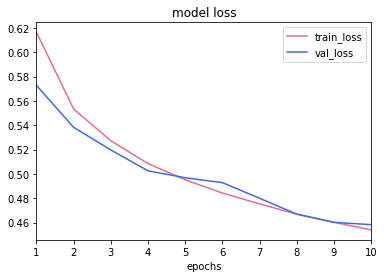

In [ ]:
# learning curve 그리기 - loss
plt.title('model loss')
plt.xlabel('epochs')
# plt.style.use('')
plt.plot(10, history.history['loss'], 'palevioletred', label='train_loss')
plt.plot(10, history.history['val_loss'], 'royalblue', label='val_loss')
plt.legend()
plt.xlim(1, 10)
plt.ylim()
plt.show()

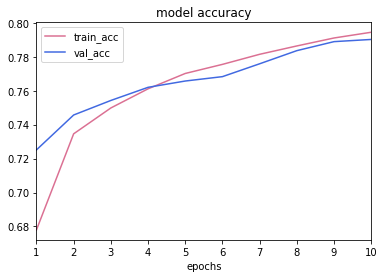

In [ ]:
# learning curve 그리기 - accuracy
plt.title('model accuracy')
plt.xlabel('epochs')
plt.plot(10, history.history['accuracy'], 'palevioletred', label='train_acc')
plt.plot(10, history.history['val_accuracy'], 'royalblue', label='val_acc')
plt.xlim(1, 10)
plt.legend()
plt.show()

In [ ]:
test_generator = My_Custom_Generator(test_filepath, y_test, batch_size)


In [ ]:
prediction = mymodel.predict(
    test_generator,
    verbose=1,
    steps = int(len(test_filepath) // batch_size) + 1 
    )

# 4. 추론

## 4.1. machine learning

In [ ]:
# 뺄까요? (발표자료에 없음)

# XL 데이터의 예측 값
y_rf_proba_XL = rf.predict_proba(y_test_XL)
y_svc_proba_XL = svc.predict_proba(y_test_XL)
y_mlp_proba_XL = mlp.predict_proba(y_test_XL)

np.save('경로', rf)
np.save('경로', svc)
np.save('경로', mlp)

In [ ]:
# 뺄까요? (발표자료에 없음)

np.savez_compressed("./npy/ML_prob.npz", rf_pred=y_rf_proba, svc_pred=y_svc_proba, mlp_pred=y_mlp_proba,
rf_pred_XL=y_rf_proba_XL, svc_pred_XL=y_svc_proba_XL, mlp_pred_XL=y_mlp_proba_XL,
label = y_test, label_XL =y_test_XL)

## 4.2. deep learning(backbone)

In [ ]:
# 데이터셋 할당 및 데이터로더(제너레이터) 할당
XL_testset = CustomImageDataset(r'C:\Users\Public\project3\real_csv\test_XL_sh.csv', transform=transform)
XL_testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=0)

In [ ]:
# e2s) inference 실행 및 결과를 변수에 할당
XL_logit_list_e2s, XL_pred_list_e2s, XL_accuracy_e2s = test_model(e2s, XL_testloader)

[  1/209] batch completed
[  2/209] batch completed
[  3/209] batch completed
[  4/209] batch completed
[  5/209] batch completed
[  6/209] batch completed
[  7/209] batch completed
[  8/209] batch completed
[  9/209] batch completed
[ 10/209] batch completed
[ 11/209] batch completed
[ 12/209] batch completed
[ 13/209] batch completed
[ 14/209] batch completed
[ 15/209] batch completed
[ 16/209] batch completed
[ 17/209] batch completed
[ 18/209] batch completed
[ 19/209] batch completed
[ 20/209] batch completed
[ 21/209] batch completed
[ 22/209] batch completed
[ 23/209] batch completed
[ 24/209] batch completed
[ 25/209] batch completed
[ 26/209] batch completed
[ 27/209] batch completed
[ 28/209] batch completed
[ 29/209] batch completed
[ 30/209] batch completed
[ 31/209] batch completed
[ 32/209] batch completed
[ 33/209] batch completed
[ 34/209] batch completed
[ 35/209] batch completed
[ 36/209] batch completed
[ 37/209] batch completed
[ 38/209] batch completed
[ 39/209] ba

In [ ]:
# m3l) inference 실행 및 결과를 변수에 할당
XL_logit_list_m3l, XL_pred_list_m3l, XL_accuracy_m3l = test_model(m3l, XL_testloader)

In [ ]:
# confusion matrix를 만들기 위해 결과들을 하나의 텐서로 변환
XL_logit_list_e2s_tensor = torch.cat([logits for logits in XL_logit_list_e2s], dim=0)
XL_pred_list_e2s_tensor = torch.cat([preds for preds in XL_pred_list_e2s], dim=0)
XL_logit_list_m3l_tensor = torch.cat([logits for logits in XL_logit_list_m3l], dim=0)
XL_pred_list_m3l_tensor = torch.cat([preds for preds in XL_pred_list_m3l], dim=0)

# gpu 사용시 결과값을 cpu에도 저장
XL_logit_list_e2s_tensor = XL_logit_list_e2s_tensor.cpu()
XL_pred_list_e2s_tensor = XL_pred_list_e2s_tensor.cpu()
XL_logit_list_m3l_tensor = XL_logit_list_m3l_tensor.cpu()
XL_pred_list_m3l_tensor = XL_pred_list_m3l_tensor.cpu()

# 실제 label 값 변수 할당
XL_true_list = list(XL_testset.img_labels.label)

In [ ]:
# e2s backbone confusion matrix 확인
cm(true_list, XL_pred_list_e2s_tensor)

In [ ]:
# m3l backbone confusion matrix 확인
cm(true_list, XL_pred_list_m3l_tensor)

In [ ]:
# 결과 plotting을 위해 값 저장
XL_np_e2s_logit = XL_logit_list_e2s_tensor.numpy()
XL_np_e2s_pred = XL_pred_list_e2s_tensor.numpy()
XL_np_e2s_accuracy = XL_accuracy_e2s.cpu().numpy()
XL_np_m3l_logit = XL_logit_list_m3l_tensor.numpy()
XL_np_m3l_pred = XL_pred_list_m3l_tensor.numpy()
XL_np_m3l_accuracy = XL_accuracy_m3l.cpu().numpy()
XL_np_true = np.array(XL_true_list).reshape(-1, 1)

np.savez_compressed(r'C:\Users\Public\project3\real_csv\XL_backbone_logit_pred_acc.npz', e2s_logit=XL_np_e2s_logit, e2s_pred = XL_np_e2s_pred, e2s_acc = XL_np_e2s_accuracy, m3l_logit=XL_np_m3l_logit, m3l_pred=XL_np_m3l_pred, m3l_acc = XL_np_m3l_accuracy, true_label = XL_np_true)

### ROC curve 그리기

In [ ]:
# backbone의 test와 inference 실행 결과 불러옴
test = np.load('/content/drive/MyDrive/kusw_third_project/backbone_logit_pred_acc.npz')
XLtest = np.load('/content/drive/MyDrive/kusw_third_project/backboneXL_logit_pred_acc.npz')

In [ ]:
# 로짓값을 확률로 바꿔주는 sigmoid 함수 설정
def sigmoid(x):
    return 1 / (1 +np.exp(-x))

In [ ]:
# test 결과값 변수 설정
e2s_prob = sigmoid(test['e2s_logit'])
e2s_pred = test['e2s_pred']
e2s_acc = test['e2s_acc']
m3l_prob = sigmoid(test['m3l_logit'])
m3l_pred = test['m3l_pred']
m3l_acc = test['m3l_acc']
labels = test['true_label']

# inference 결과값 변수 설정
XL_e2s_prob = sigmoid(XLtest['e2s_logit'])
XL_e2s_pred = XLtest['e2s_pred']
XL_e2s_acc = XLtest['e2s_acc']
XL_m3l_prob = sigmoid(XLtest['m3l_logit'])
XL_m3l_pred = XLtest['m3l_pred']
XL_m3l_acc = XLtest['m3l_acc']
XL_labels = XLtest['true_label']

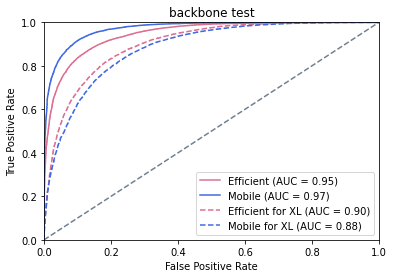

In [ ]:
# ROC curve 그리기
fpr_e, tpr_e, thresholds_e = metrics.roc_curve(labels, e2s_prob) # e2s) test 결과값에서 x축, y축 값 할당
roc_auc_e = metrics.auc(fpr_e, tpr_e) # e2s) test 결과값에서 AUC 점수 할당
fpr_m, tpr_m, thresholds_m = metrics.roc_curve(labels, m3l_prob) # m3l) test 결과값에서 x축, y축 값 할당
roc_auc_m = metrics.auc(fpr_m, tpr_m) # m3l) test 결과값에서 AUC 점수 할당
XL_fpr_e, XL_tpr_e, XL_thresholds_e = metrics.roc_curve(XL_labels, XL_e2s_prob) # e2s) inference 결과값에서 x축, y축 값 할당
XL_roc_auc_e = metrics.auc(XL_fpr_e, XL_tpr_e) # e2s) inference 결과값에서 AUC 점수 할당
XL_fpr_m, XL_tpr_m, XL_thresholds_m = metrics.roc_curve(XL_labels, XL_m3l_prob) # m3l) inference 결과값에서 x축, y축 값 할당
XL_roc_auc_m = metrics.auc(XL_fpr_m, XL_tpr_m) # m3l) inference 결과값에서 AUC 점수 할당

plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='slategray') # ROC curve 기준선 설정(AUC score 0.5)
plt.plot(fpr_e, tpr_e, color='palevioletred', label=f'Efficient (AUC = {roc_auc_e:.2f})') # test 결과에 대한 e2s ROC curve 그리기
plt.plot(fpr_m, tpr_m, color='royalblue', label=f'Mobile (AUC = {roc_auc_m:.2f})') # test 결과에 대한 m3l ROC curve 그리기
plt.plot(XL_fpr_e, XL_tpr_e, color='palevioletred', linestyle='--', label=f'Efficient for XL (AUC = {XL_roc_auc_e:.2f})') # inference 결과에 대한 e2s ROC curve 그리기
plt.plot(XL_fpr_m, XL_tpr_m, color='royalblue', linestyle='--', label=f'Mobile for XL (AUC = {XL_roc_auc_m:.2f})') # inference 결과에 대한 m3l ROC curve 그리기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('backbone test')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

## 4.3. deep learning(spectrum)

In [ ]:
test_generator_GAN = My_Custom_Generator(test_XL_filepath, y_test_XL, batch_size)

In [ ]:
prediction_GAN = mymodel.predict(
    test_generator_GAN,
    verbose=1,
    steps = int(len(test_XL_filepath) // batch_size) + 1,
    )

In [ ]:
np.savez_compressed("경로", test_pred=prediction[:, 0], test_label=y_test,
XL_pred=prediction_GAN[:, 0], XL_label=y_test_XL)

In [ ]:
loaded = np.load("pred_spectrum.npz")

In [ ]:
vars(loaded)

In [ ]:
sp_prob = loaded['test_pred']
sp_true = loaded['test_label']
XL_sp_prob = loaded['XL_pred']
XL_sp_true = loaded['XL_label']

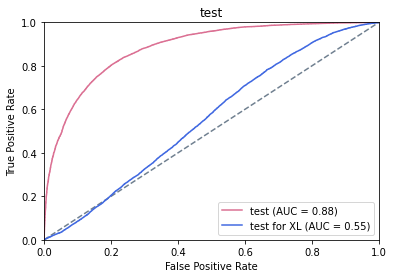

In [ ]:
fpr_sp, tpr_sp, thresholds_sp = metrics.roc_curve(sp_true, sp_prob)
roc_auc_sp = metrics.auc(fpr_sp, tpr_sp)
XL_fpr_sp, XL_tpr_sp, XL_thresholds_sp = metrics.roc_curve(XL_sp_true, XL_sp_prob)
XL_roc_auc_sp = metrics.auc(XL_fpr_sp, XL_tpr_sp)

plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='slategray')
plt.plot(fpr_sp, tpr_sp, color='palevioletred', label=f'test (AUC = {XL_roc_auc_sp:.2f})')
plt.plot(XL_fpr_sp, XL_tpr_sp, color='royalblue', label=f'test for XL (AUC = {XL_roc_auc_sp:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('test')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()